# Analysis notebook

In this notebook, we will perform a simple data analysis task. Analysis is performed in the following way:
1. Create ntuple with all needed variables (done)
2. Analyse each event, and store the output in a new ntuple
3. Dump the data into histograms/arrays
4. Interpret the results 

The first step is usually done using the CMS Software ([CMSSW](http://cms-sw.github.io/)), and the output is flat ROOT ntuple. The second step can be done either in ROOT using C++ macros or using a jupyter notebook.

The code for event-based analysis has the following structure:
```python
#loop over all events and extract high-level variables
for event in tree:
  do_somthing
  variables['var1']=var1
  ...

#(Optional) Store the variables (example with pandas dataframe)
df = pd.DataFrame(data=variables)
df.to_csv('results.csv', index = False)
```

In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed

Welcome to JupyROOT 6.24/00


In [2]:
#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [3]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_PU140_NTUPLE_1_version3.root'

In [4]:
#load the file
tree = uproot.open(filename+":myana/mytree")

## Analysis of di-muon events

In the following example, we are interested in studying muons coming from the exclusive production mode. Before we start, let's look at the data and count how many muons we have per event:

In [5]:
#obtain N arrays, where N = number of events, and array is an array of PF candidates with |PID|=13 (muons)
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13')

In [6]:
#for example let's print pT of all muons from the first event:
print(muons.pfcand_pt[0])

[0.916, 0.752, 0.937, 31, 30.7, 1.24, 1.39, ... 1.81, 1.27, 1.55, 1.03, 1.07, 1.24]


In [7]:
#to get the number of muons in event we we will loop over all entries and append length of the muon array:
N = len(muons)
n_muons = []
for i in range(N):
    n_muons.append(len(muons.pfcand_pt[i]))

[Text(1, 14.0, 'Number of muons in event'), Text(40.5, 1, 'number of entries')]

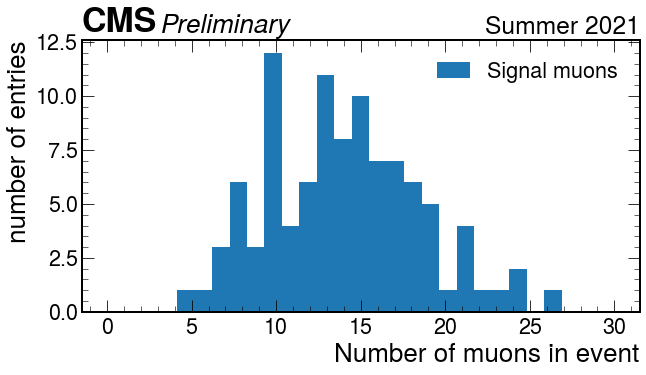

In [8]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(n_muons, bins=np.linspace(0,30,30),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('Analyse/number_muons_signal.png',bbox_inches='tight')

As shown in the example above, there are more than two muons in the process $pp\to p \oplus \mu \mu \oplus p$. Where are other muons coming from? To understand it better, let's look at the muon rapidity (or [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity) as muon mass is negligible compare to the momentum):
`muons.pfcand_eta` is a [awkward.highlevel.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) array with non regular vector size (each event has different number of muons). To plot all muons together we need to use `ak.layout.Content` to make a single array of all muons, and then call `awkward.to_numpy(array)` to convert the output to [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)

[Text(1, 14.0, '$\\eta$ of muons'), Text(46.5, 1, 'number of entries')]

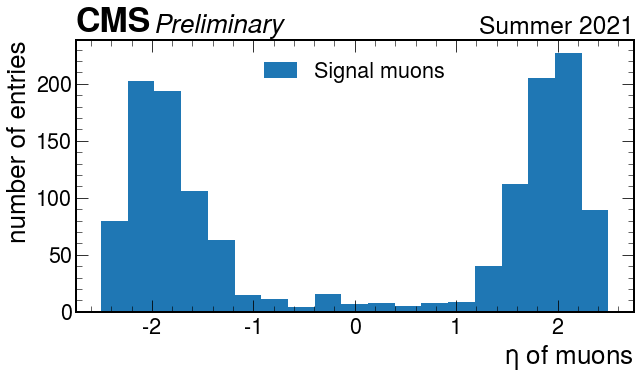

In [9]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(awkward.to_numpy(muons.pfcand_eta.layout.content), bins=np.linspace(-2.5,2.5,20),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\eta$ of muons', ylabel='number of entries')
#plt.savefig('Analyse/muon_eta.png',bbox_inches='tight')

OK, we see that most of the muons are in the forward region. This is because particles (like pions) pass through more material moving forward (backward) and tend to decay, so more muons are produced.

See for example, expected trigger rate for muons with $p_T>$ 10 GeV at HL-LHC for ATLAS experiment (Fig 2.6 of [CERN-LHCC-2013-006](https://cds.cern.ch/record/1552862)):

<img src="http://cds.cern.ch/record/2641653/files/trigger-rate.png" width=600 height=400 />


### Selecting signal muons

Muons originating from pion decay or other pileup interactions are usually very soft. To select signal muons, we will select two opposite sign leading muons. To do it, we need to loop over all events and construct a new dataframe with the relevant information.

In [10]:
N = len(muons) # number of events

#define dataframe
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=np.zeros(N)
    data['mu2_'+k]=np.zeros(N)

# add  info for di-muon invariant mass
data['mll']=np.zeros(N)

#loop over all events
for i in tqdm(range(N)): 
    
    #loop over all muons in event, and add two muons with higest pT to the data
    mu=muons[i]
    for i_mu, pt in enumerate(mu.pfcand_pt):
        #check if muon has higher pT than mu1_pt
        if pt > data['mu1_pt'][i]:
            #if yes, set mu2=mu1, and update values for mu1
            for k in ['pt','eta','phi','m','t','vz']:
                data['mu2_'+k][i] = data['mu1_'+k][i]
            data['mu1_pt'][i] = mu.pfcand_pt[i_mu]
            data['mu1_eta'][i] = mu.pfcand_eta[i_mu]
            data['mu1_phi'][i] = mu.pfcand_phi[i_mu]
            data['mu1_m'][i] = mu.pfcand_mass[i_mu]
            data['mu1_t'][i] = mu.pfcand_t[i_mu]
            data['mu1_vz'][i] = mu.pfcand_vz[i_mu]
        
        #check if muon has higher pT than mu2_pt
        elif pt > data['mu2_pt'][i]:
            #if yes, update values for mu2
            data['mu2_pt'][i] = mu.pfcand_pt[i_mu]
            data['mu2_eta'][i] = mu.pfcand_eta[i_mu]
            data['mu2_phi'][i] = mu.pfcand_phi[i_mu]
            data['mu2_m'][i] = mu.pfcand_mass[i_mu]
            data['mu2_t'][i] = mu.pfcand_t[i_mu]
            data['mu2_vz'][i] = mu.pfcand_vz[i_mu]
            
    #calculate invariante mass from two muons:
    mu1=ROOT.Math.PtEtaPhiMVector(data['mu1_pt'][i], data['mu1_phi'][i], data['mu1_eta'][i], data['mu1_m'][i])
    mu2=ROOT.Math.PtEtaPhiMVector(data['mu2_pt'][i], data['mu2_phi'][i], data['mu2_eta'][i], data['mu2_m'][i])
    data['mll'][i] = (mu1+mu2).M()

    #print pT of the two leading muons:
    #print('Event=',i,': muons pT = ',muons_anal['mu1_pt'][i],muons_anal['mu2_pt'][i], ' invariant mass = ',muons_anal['mll'][i])


100%|██████████| 100/100 [00:00<00:00, 143.68it/s]


In [11]:
#create dataframe
muons_anal = pd.DataFrame(data=data)

Now we will plot the invariant mass of two leptons, and the $\eta$ distribution of signal leptons:

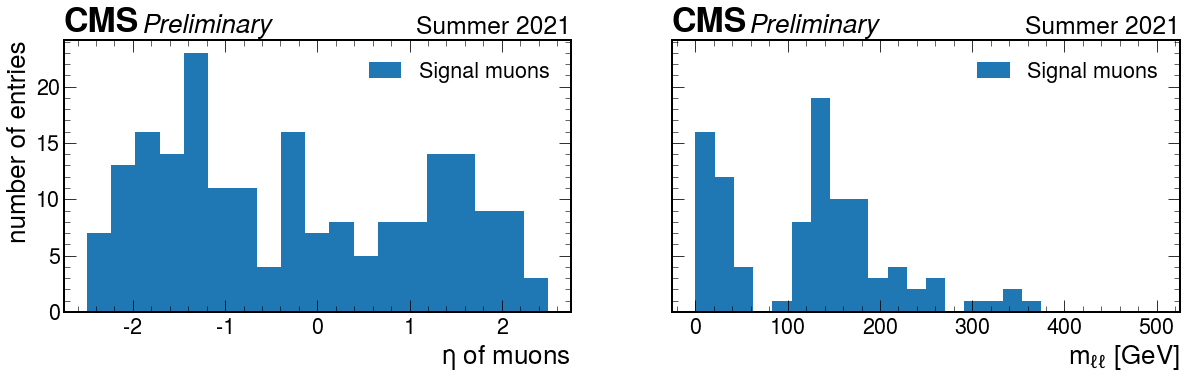

In [12]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].hist(np.concatenate([muons_anal['mu1_eta'].values,muons_anal['mu2_eta'].values]), bins=np.linspace(-2.5,2.5,20),label='Signal muons')
ax[0].set(xlabel=r'$\eta$ of muons', ylabel='number of entries')

ax[1].hist(muons_anal['mll'].values, bins=np.linspace(0,500,25),label='Signal muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
#plt.savefig('Analyse/dimuon_analysis.png',bbox_inches='tight')

NOTE: the low $m_{\ell\ell}$ entries are from backgound muons, easy to see it using 2D scatter plot between leading muon $p_T$ and invariant mass:

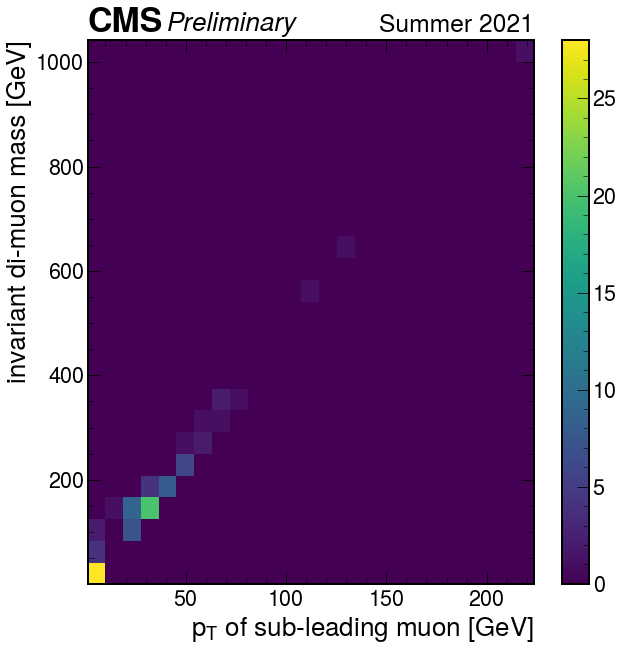

In [13]:
fig, axes = plt.subplots(figsize=(10,10) )
h = axes.hist2d( muons_anal['mu2_pt'].values, muons_anal['mll'].values, bins=(25,25) , cmap='viridis')
axes.set(xlabel=r'$p_T$ of sub-leading muon [GeV]', ylabel='invariant di-muon mass [GeV]')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
fig.colorbar(h[3], ax=axes)
#plt.savefig('Analyse/dimuon_analysis_correlation.png')

### Event variables and signal muons

In the next cell, we will plot the correlation between the time measured for each one of the muons and the actual time the collision happens (`genvtx_t0`).

In [14]:
#get the event info:
event_info = tree.arrays(['genvtx_t0'])

We copy-paste the analysis cell here, adding event info to the dataframe:

In [15]:
N = len(muons) # number of events

#define dataframe
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=np.zeros(N)
    data['mu2_'+k]=np.zeros(N)

# add  info for di-muon invariant mass
data['mll']=np.zeros(N)
data['evt_t0']=np.zeros(N)

#loop over all events
for i in tqdm(range(N)): 
    
    #loop over all muons in event, and add two muons with higest pT to the data
    mu=muons[i]
    ev=event_info[i]
    for i_mu, pt in enumerate(mu.pfcand_pt):
        #check if muon has higher pT than mu1_pt
        if pt > data['mu1_pt'][i]:
            #if yes, set mu2=mu1, and update values for mu1
            for k in ['pt','eta','phi','m','t','vz']:
                data['mu2_'+k][i] = data['mu1_'+k][i]
            data['mu1_pt'][i] = mu.pfcand_pt[i_mu]
            data['mu1_eta'][i] = mu.pfcand_eta[i_mu]
            data['mu1_phi'][i] = mu.pfcand_phi[i_mu]
            data['mu1_m'][i] = mu.pfcand_mass[i_mu]
            data['mu1_t'][i] = mu.pfcand_t[i_mu]
            data['mu1_vz'][i] = mu.pfcand_vz[i_mu]
        
        #check if muon has higher pT than mu2_pt
        elif pt > data['mu2_pt'][i]:
            #if yes, update values for mu2
            data['mu2_pt'][i] = mu.pfcand_pt[i_mu]
            data['mu2_eta'][i] = mu.pfcand_eta[i_mu]
            data['mu2_phi'][i] = mu.pfcand_phi[i_mu]
            data['mu2_m'][i] = mu.pfcand_mass[i_mu]
            data['mu2_t'][i] = mu.pfcand_t[i_mu]
            data['mu2_vz'][i] = mu.pfcand_vz[i_mu]
            
    #calculate invariante mass from two muons:
    mu1=ROOT.Math.PtEtaPhiMVector(data['mu1_pt'][i], data['mu1_phi'][i], data['mu1_eta'][i], data['mu1_m'][i])
    mu2=ROOT.Math.PtEtaPhiMVector(data['mu2_pt'][i], data['mu2_phi'][i], data['mu2_eta'][i], data['mu2_m'][i])
    data['mll'][i] = (mu1+mu2).M()
    
    #add event info variables:
    data['evt_t0'][i]=ev.genvtx_t0

100%|██████████| 100/100 [00:00<00:00, 214.32it/s]


In [16]:
#create dataframe
analysis = pd.DataFrame(data=data)

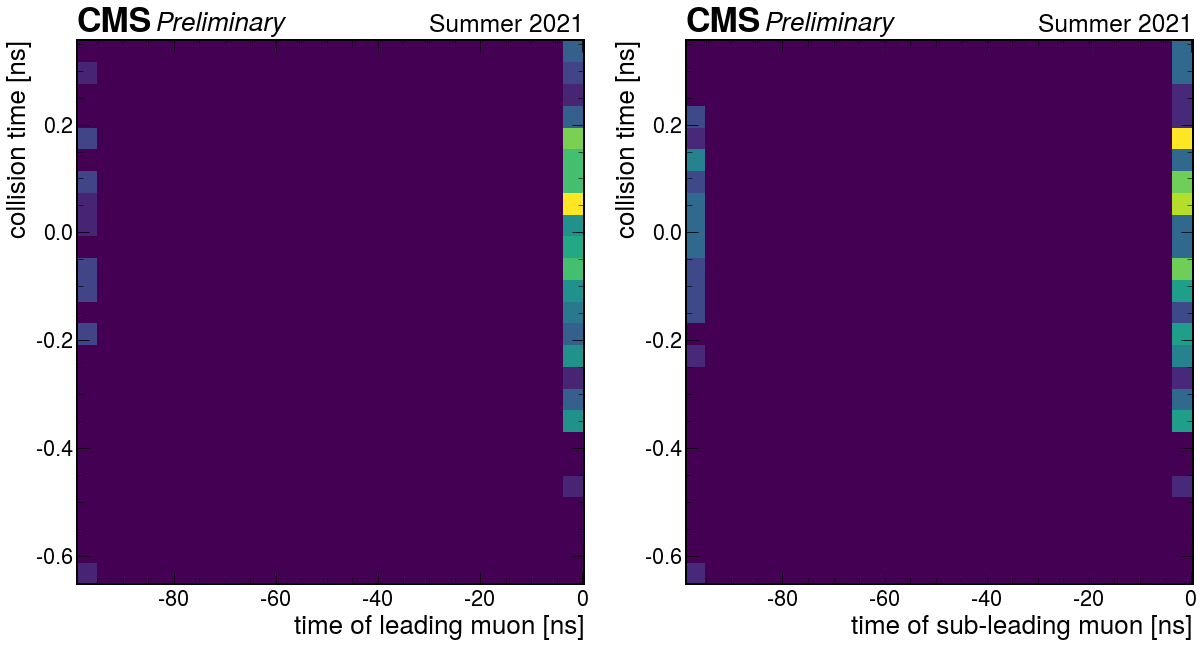

In [17]:
#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
axes[0].hist2d( analysis['mu1_t'].values, analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')

axes[1].hist2d( analysis['mu2_t'].values, analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])
#plt.savefig('Analyse/dimuon_analysis_time_correlation.png')

NOTE: some muons don't have reconstructed time, therefore their `t=-99` When working with pandas dataframe it useful to **mask** events (filter) before plotting:

### MIP Timining Detector (MTD) resolution

In the following cell we will plot the MTD timing resolution as obtained from the simulation. Resoluiton is measured in percent (%) and defined by the standard variation of the difference between recontructed and true values:
$ \sigma^2 = \frac{1}{N-1}\Sigma \left(t_{rec} - t_{true}\right)^2 $

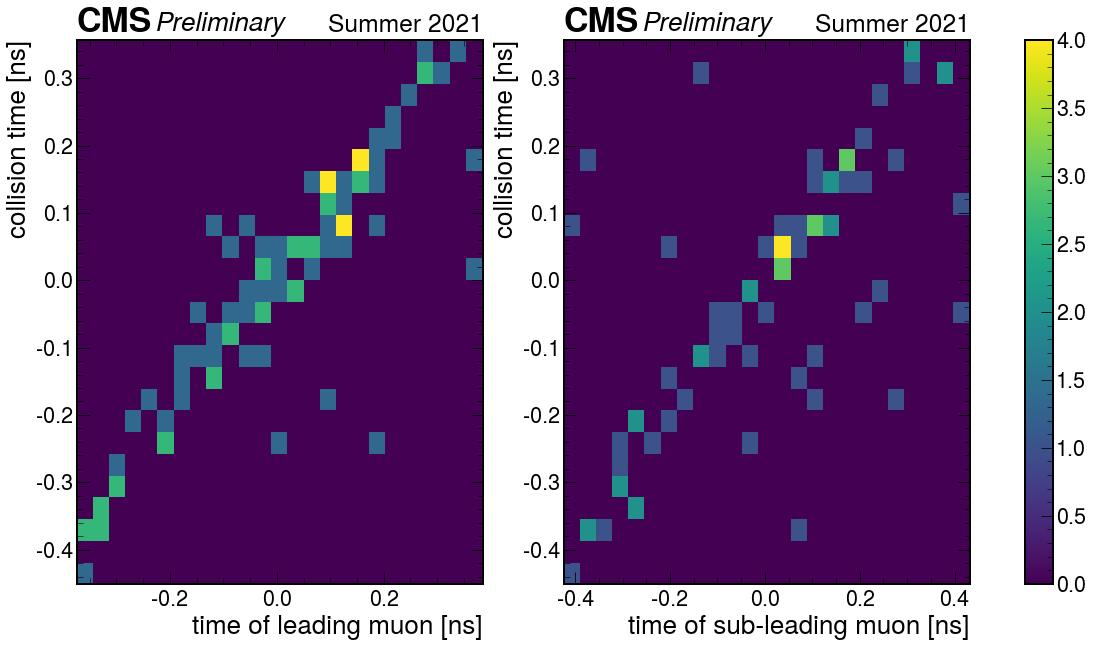

In [18]:
mask_muon1_measured_time = analysis['mu1_t']>-80
mask_muon2_measured_time = analysis['mu2_t']>-80

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
masked_analysis=analysis[mask_muon1_measured_time]
axes[0].hist2d( masked_analysis['mu1_t'].values, masked_analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')
masked_analysis=analysis[mask_muon2_measured_time]
h = axes[1].hist2d( masked_analysis['mu2_t'].values, masked_analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')
fig.colorbar(h[3], ax=axes)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('Analyse/dimuon_analysis_time_correlation2.png')

In [19]:
recontsructed_time_resolution1 = analysis[mask_muon1_measured_time]['mu1_t'].values - analysis[mask_muon1_measured_time]['evt_t0'].values
recontsructed_time_resolution2 = analysis[mask_muon2_measured_time]['mu2_t'].values - analysis[mask_muon2_measured_time]['evt_t0'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

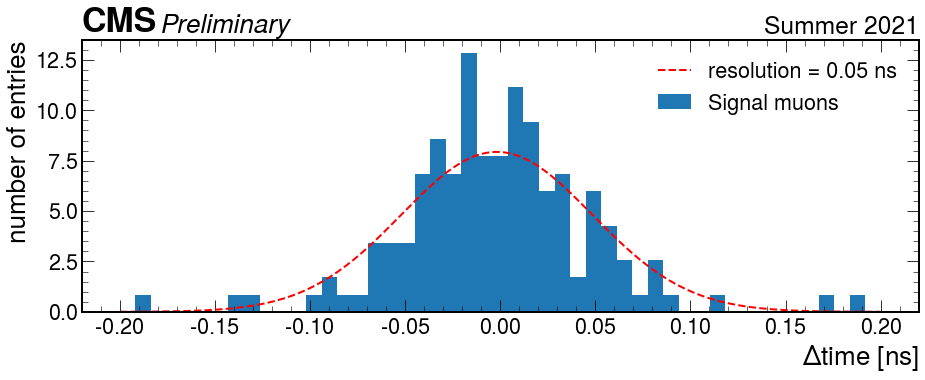

In [20]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Signal muons')
ax.set(xlabel=r'$\Delta time$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
#plt.savefig('Analyse/MTD_resolution.png',bbox_inches='tight')

100
200


(0.0, 0.2)

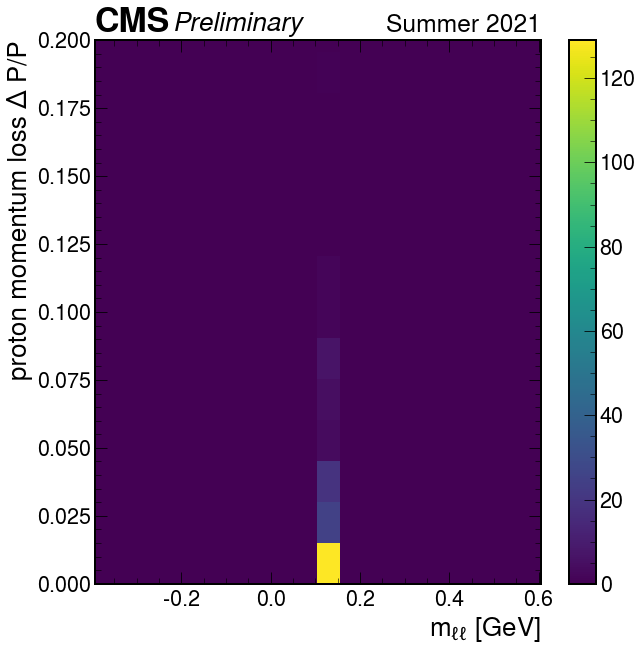

In [21]:
import matplotlib as mpl
protons = tree.arrays(['genproton_xi','genproton_ispu'],library="pd")
prot = protons[protons.genproton_ispu==0]['genproton_xi'].values
fig, axes = plt.subplots(figsize=(10,10) )
print(len(muons_anal['mu1_m']))#100
muon = np.append(muons_anal['mu1_m'], muons_anal['mu2_m'])
print(len(prot))#200
#first and 2nd leading muon combined 
im = axes.hist2d( muon, prot, bins=(20,20) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'$m_{\ell\ell}$ [GeV]', ylabel='proton momentum loss \u0394 P/P')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
plt.ylim(0,0.2)
#cax,kw = mpl.colorbar.make_axes()
#plt.savefig('Analyse/dimuon_mass_xi_correlation.png')

100
200


(0.0, 0.2)

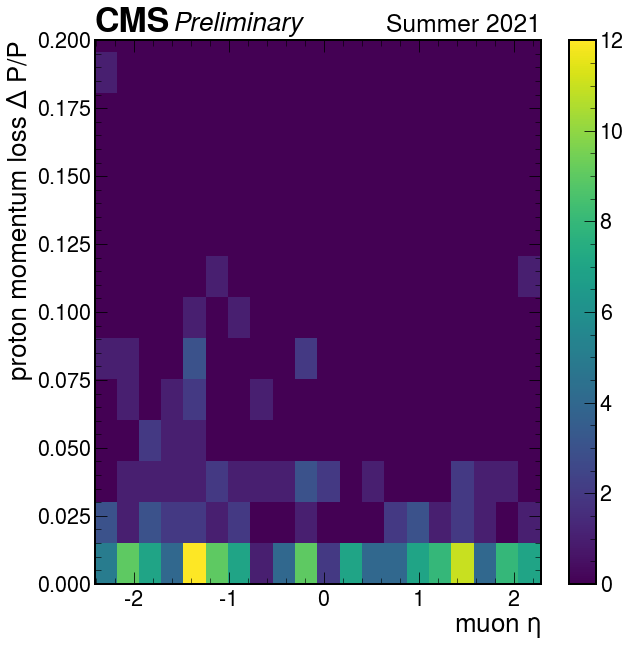

In [22]:
import matplotlib as mpl
protons = tree.arrays(['genproton_xi','genproton_ispu'],library="pd")
prot = protons[protons.genproton_ispu==0]['genproton_xi'].values
fig, axes = plt.subplots(figsize=(10,10) )
print(len(muons_anal['mu1_eta']))#100
muon = np.append(muons_anal['mu1_eta'], muons_anal['mu2_eta'])
print(len(prot))#200
#first and 2nd leading muon combined 
im = axes.hist2d( np.concatenate([muons_anal['mu1_eta'].values,muons_anal['mu2_eta'].values]), prot, bins=(20,20) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'muon $\eta  $', ylabel='proton momentum loss \u0394 P/P')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
plt.ylim(0,0.2)
#cax,kw = mpl.colorbar.make_axes()
#plt.savefig('Analyse/dimuon_eta_xi_correlation_concentrate.png')

100
100
200


(-20.0, 9.0)

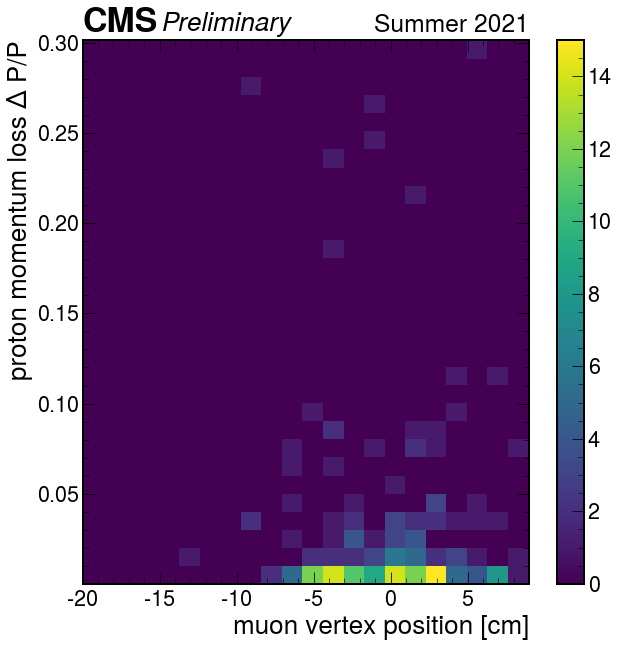

In [23]:
#protons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13')
import matplotlib as mpl
protons = tree.arrays(['genproton_xi','genproton_ispu'],library="pd")
prot = protons[protons.genproton_ispu==0]['genproton_xi'].values
fig, axes = plt.subplots(figsize=(10,10) )
print(len(muons_anal['mu2_vz']))#100
print(len(muons_anal['mu1_vz']))
#first and 2nd leading muon combined 
muon = np.append(muons_anal['mu2_vz'].values, muons_anal['mu1_vz'].values)
print(len(prot))#200
im = axes.hist2d(muon, prot, bins=(30,30) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'muon vertex position [cm]', ylabel='proton momentum loss \u0394 P/P')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
plt.xlim(-20,9)
#cax,kw = mpl.colorbar.make_axes()
#plt.savefig('Analyse/dimuon_analysis_vz_corr_xi.png')

200


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

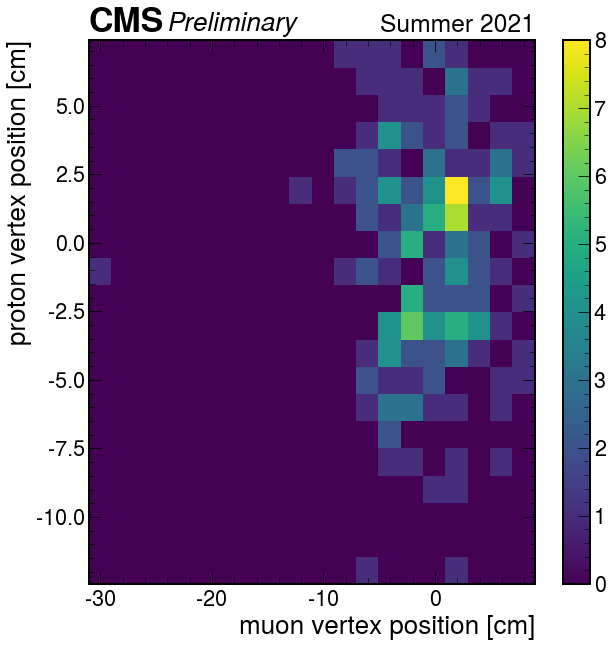

In [110]:
#protons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13')
import matplotlib as mpl
protons = tree.arrays(['genproton_vz','genproton_ispu'],library="pd")
prot = protons[protons.genproton_ispu==0]['genproton_vz'].values
p = tree['genproton_vz'].array(library = "pd")
fig, axes = plt.subplots(figsize=(10,10) )
muon = np.append(muons_anal['mu1_vz'].values,muons_anal['mu2_vz'].values)
print(len(prot))#200 np.concatenate([muons_anal['mu1_vz'].values,muons_anal['mu2_vz'].values])
im = axes.hist2d(muon, prot, bins=(20,20) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'muon vertex position [cm]', ylabel='proton vertex position [cm]')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
#plt.xlim(-10,9)
#cax,kw = mpl.colorbar.make_axes()
#plt.savefig('Analyse/vz_prot_sig_mu_corr.png')

In [ ]:
import matplotlib as mpl

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
masked_analysis=analysis[mask_muon1_measured_time]
axes[0].hist2d(muons_anal['mu1_eta'], muons_anal['mu1_m'].values, bins=(20,20) , cmap='viridis')
axes[0].set(xlabel=r'leading muon $\eta  $', ylabel='$m_{\ell, leading}$ [GeV]')
plt.ylim(0,0.2)
h = axes[1].hist2d(muons_anal['mu2_eta'], muons_anal['mu2_m'].values, bins=(20,20) , cmap='viridis')
axes[1].set(xlabel=r'subleading muon $\eta  $', ylabel='$m_{\ell, subleading}$ [GeV]')
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/dimuon_analysis_eta_mass.png')

In [ ]:
#you should see an agreement unless the primary vertex is not the one from two muons.

76
100
76
100


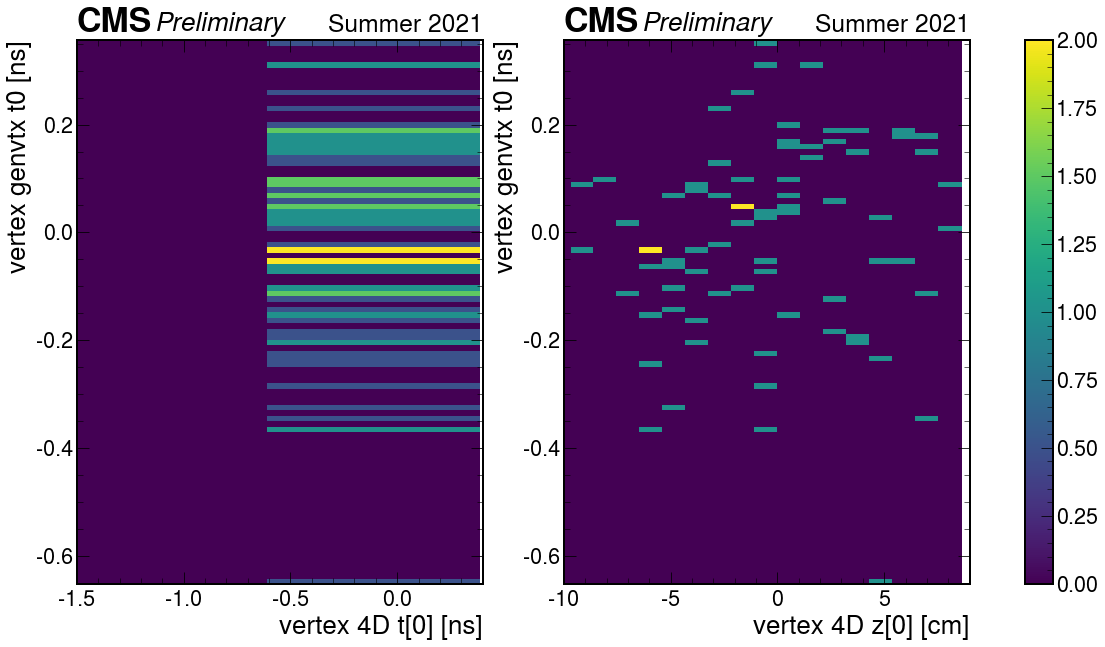

In [83]:
import matplotlib as mpl
# If you plot the correlation between vtx4D_t[0]  and genvtx_t0 OR 

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
genvtx = tree['genvtx_t0'].array(library="pd")
#genvtx = tree['genproton_vz'].array(library = "pd")
vtx4Dt = tree['vtx4D_t'].array(library = "pd")
vtx4Dz = tree['vtx4D_z'].array(library = "pd")
print(len(vtx4Dt[0]))
print(len(genvtx))
print(len(vtx4Dz[0]))

#vtx = np.append(genvtx[0], -99)
t = np.append(vtx4Dt[0],-99)
z = np.append(vtx4Dz[0], -99)
for i in range(0,23):
    t = np.append(t,-99)
    z = np.append(z, -99)
    i = i+1
print(len(t))
axes[0].hist2d(t, genvtx, bins=(100,100) , cmap='viridis')
axes[0].set(xlabel=r'vertex 4D t[0] [ns]', ylabel='vertex genvtx t0 [ns]')
axes[0].set_xlim(-1.5,0.4)
#axes[0].set_ylim(-10,8)
h = axes[1].hist2d(z, genvtx, bins=(100,100) , cmap='viridis')
axes[1].set(xlabel=r'vertex 4D z[0] [cm]', ylabel='vertex genvtx t0 [ns]')
fig.colorbar(h[3], ax=axes)
axes[1].set_xlim(-10,9)
#axes[1].set_ylim(-10,8)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_vtx4D0_genvtx.png')

76
76


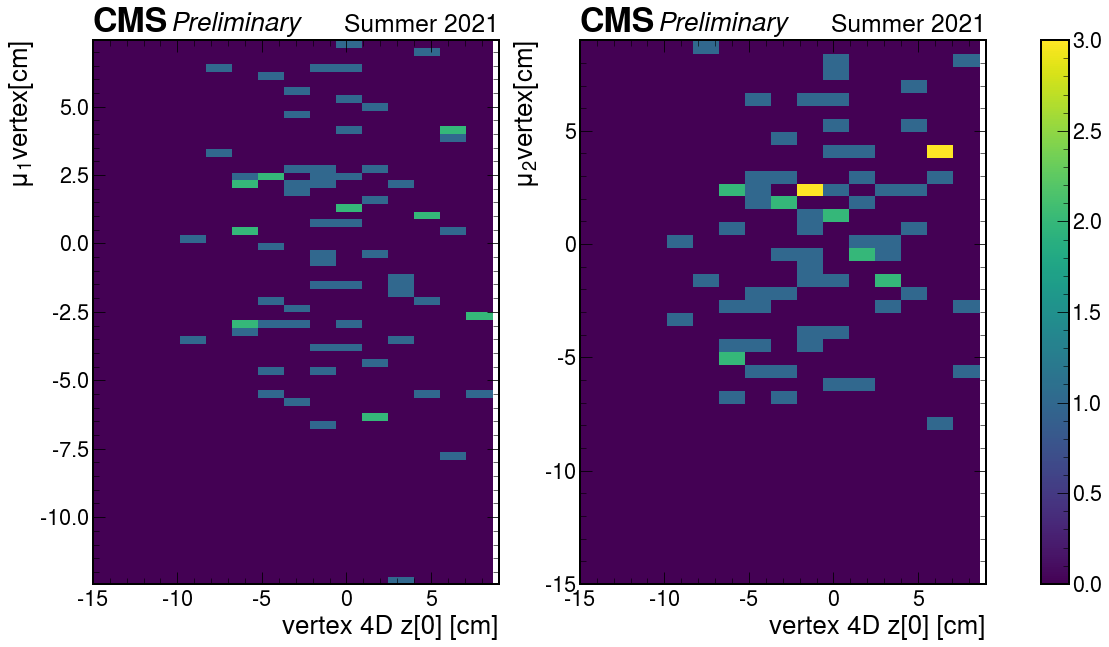

In [25]:
 #vtx4D_t[0]  and mu[1,2]_t OR  vtx4D_z[0]  and mu[1,2]_vz

import matplotlib as mpl
#(muons_anal['mu2_vz'].values, muons_anal['mu1_vz'].values)

fig, axes = plt.subplots(1,2,figsize=(20,10) )
genvtx = tree['genvtx_t0'].array(library="pd")
vtx4Dt = tree['vtx4D_t'].array(library = "pd")
vtx4Dz = tree['vtx4D_z'].array(library = "pd")
print(len(vtx4Dt[0]))
print(len(vtx4Dz[0]))
#bins=(-30,30,76)
t = np.append(vtx4Dt[0],-99)
z = np.append(vtx4Dz[0], -99)
for i in range(0,23):
    t = np.append(t,-99)
    z = np.append(z, -99)
    i = i+1
    
axes[0].hist2d(z, muons_anal['mu1_vz'].values, bins=(70,70) , cmap='viridis')
axes[0].set(xlabel=r'vertex 4D z[0] [cm]', ylabel=r'$\mu_{1} vertex [cm] $')
axes[0].set_xlim(-15,9)
#axes[0].set_ylim(-15,9)

h = axes[1].hist2d(z, muons_anal['mu2_vz'].values, bins=(70,70) , cmap='viridis')
axes[1].set(xlabel=r'vertex 4D z[0] [cm]', ylabel=r'$\mu_{2} vertex [cm] $')
axes[1].set_xlim(-15,9)
axes[1].set_ylim(-15,9)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_vtx4Dz0_mu1mu2.png')

200


(-10.0, 9.0)

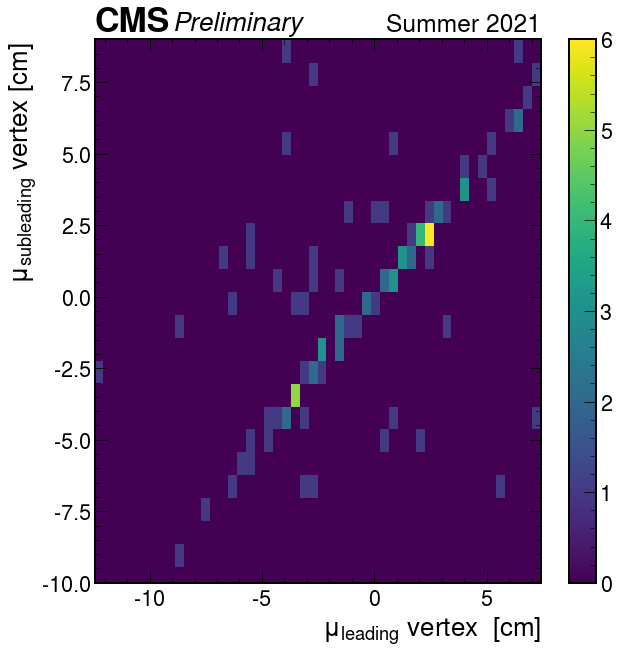

In [26]:
import matplotlib as mpl
fig, axes = plt.subplots(figsize=(10,10) )
print(len(prot))#200
im = axes.hist2d(muons_anal['mu1_vz'].values , muons_anal['mu2_vz'].values, bins=(50,50) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'$\mu_{leading}$ vertex  [cm]', ylabel=r'$\mu_{subleading}$ vertex [cm] ')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
plt.ylim(-10,9)
#plt.savefig('AnalyseW2/corr_vertex_mu1mu2.png')

76
76


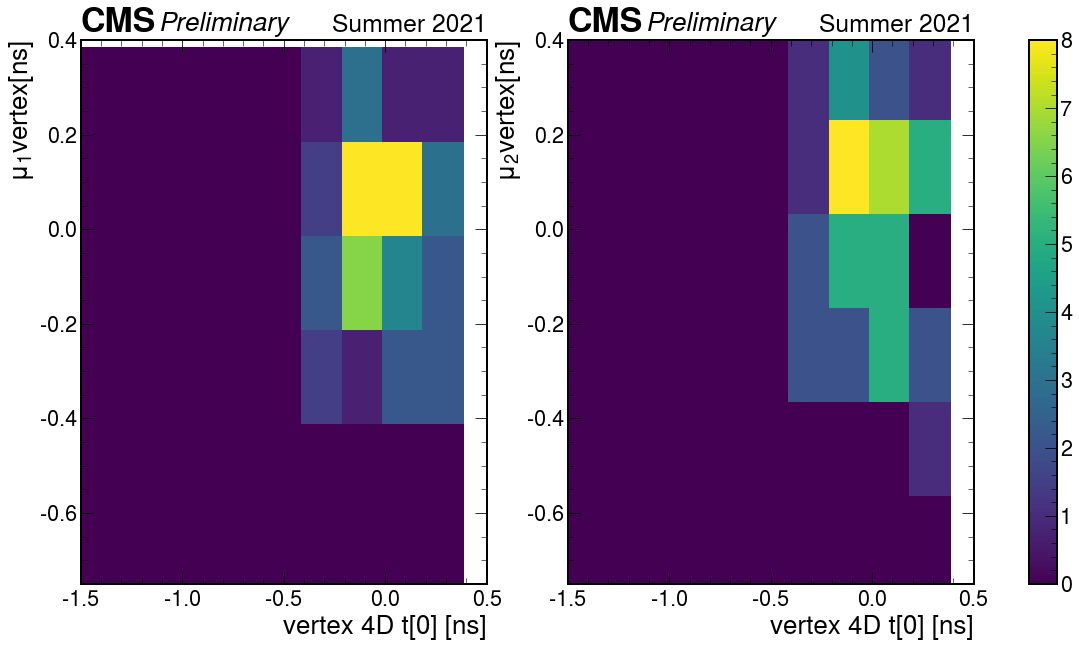

In [27]:
#vtx4D_t[0]  and mu[1,2]_t

import matplotlib as mpl
#(muons_anal['mu2_vz'].values, muons_anal['mu1_vz'].values)

fig, axes = plt.subplots(1,2,figsize=(20,10) )
genvtx = tree['genvtx_t0'].array(library="pd")
vtx4Dt = tree['vtx4D_t'].array(library = "pd")
vtx4Dz = tree['vtx4D_z'].array(library = "pd")
print(len(vtx4Dt[0]))
print(len(vtx4Dz[0]))
#bins=(-30,30,76)
t = np.append(vtx4Dt[0],-99)
z = np.append(vtx4Dz[0], -99)
for i in range(0,23):
    t = np.append(t,-99)
    z = np.append(z, -99)
    i = i+1
    
axes[0].hist2d(t, muons_anal['mu1_t'].values, bins=(500,500) , cmap='viridis')
axes[0].set(xlabel=r'vertex 4D t[0] [ns]', ylabel=r'$\mu_{1} vertex [ns] $')
axes[0].set_xlim(-1.5,0.5)
axes[0].set_ylim(-0.75,0.4)

h = axes[1].hist2d(t, muons_anal['mu2_t'].values, bins=(500,500) , cmap='viridis')
axes[1].set(xlabel=r'vertex 4D t[0] [ns]', ylabel=r'$\mu_{2} vertex [ns] $')
axes[1].set_xlim(-1.5,0.5)
axes[1].set_ylim(-0.75,0.4)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_vtx4Dt0_mu1mu2.png')

entry  subentry
0      0           0.0
       1           0.0
       2           0.0
       3           0.0
       4           0.0
                  ... 
99     67          0.0
       68          0.0
       69          0.0
       70          0.0
       71          0.0
Length: 9086, dtype: float32


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

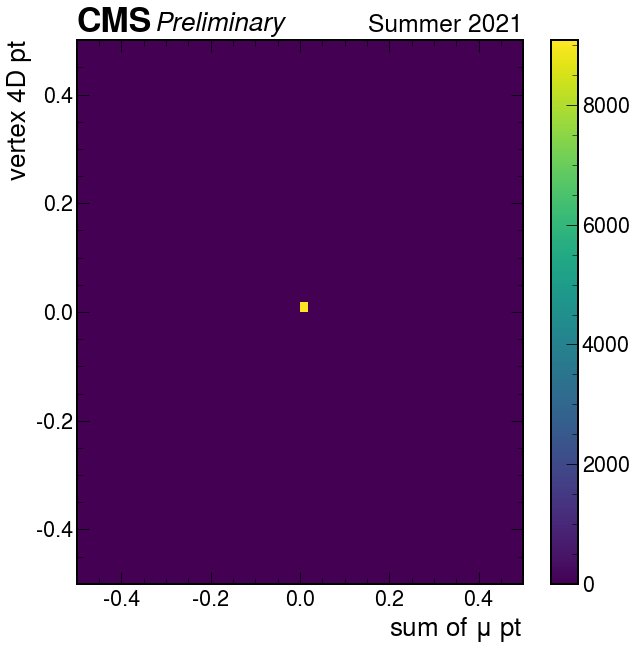

In [53]:
#if it doesn't agree - you might try to match Sum_pT of two muons ((mu1_pt+mu2_pt)**2) with vtx4D_pt2
vtx = tree['vtx4D_pt2'].array(library ="pd")
muon = pow((analysis['mu1_pt'].values + analysis['mu2_pt'].values),2)

fig, axes = plt.subplots(figsize=(10,10) )
print(vtx)#200

#print(len(muon))
im = axes.hist2d(vtx , vtx, bins=(50,50) , cmap='viridis')
fig.colorbar(im[3], ax=axes)
axes.set(xlabel=r'sum of $\mu$ pt ', ylabel=r'vertex 4D pt')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes)
#plt.ylim(-10,9)
#plt.savefig('AnalyseW2/corr_pt_vtx4D.png')


In [121]:
#compute mpp, Ypp, mll and Yll, where di-proton kinematics array contains all possible proton pairs.
 

In [122]:
#Plot mpp vs mll for signal and pule-up pairs.

In [123]:
#Define cut on (mpp-mll)/mpp and see which signal and background rates one can expect with a given cut.